## GAN

A GAN network consists of a generator and a discriminator

* Generator - goal is to generate samples with same probability distributions as the training samples in order to trick the discriminator in believing these generated samples are real --> -->
* Discriminator - goal is to classify a sample as either real or fake.

In summary we have two neural networks competing against each other, where one is the adversary of the other. This results in a zero-sum game where the generators purpose is to maximise the discriminators loss and the discriminator aims to minimize its loss.

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


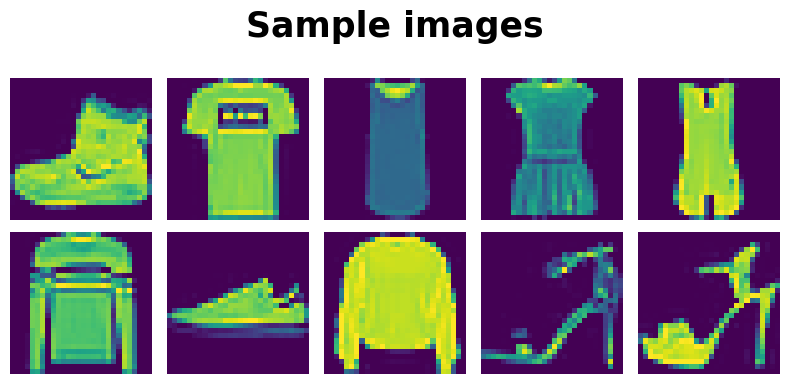

In [3]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

def display_images(data, title = "Sample images"):
    fig, axes = plt.subplots(2, 5, figsize=(8, 4))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i])
        ax.axis("off")

    fig.suptitle(title, fontsize=25, fontweight="bold")
    fig.set_tight_layout("tight")

display_images(X_train)


## Prepare data

* create batches

In [5]:
import tensorflow as tf 

batch_size = 32
X_train = X_train.astype("float32")/255
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

<class 'numpy.ndarray'>


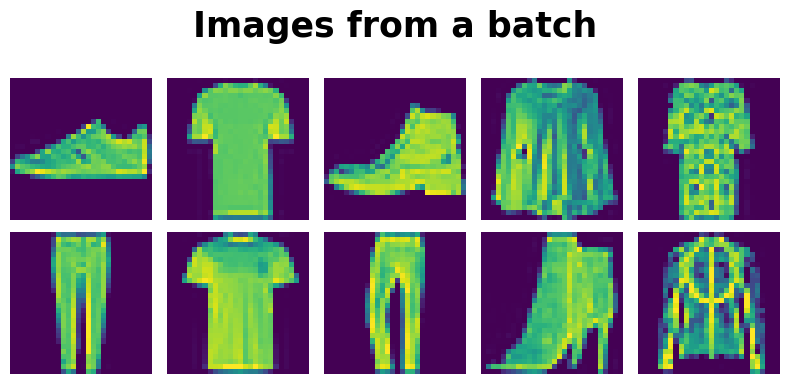

In [6]:
# takes 1 batch from the dataset which is an iterator 
for data in dataset.take(1):
    print(type(data.numpy()))
    display_images(data.numpy(), "Images from a batch")


## Build model

* generator - an MLP that takes Gaussian noise as input and outputs an image

* discriminator - an MLP that performs binary classification

In [7]:
import keras
from keras import layers
from keras.initializers import LecunNormal

coding_size = 30
image_shape = X_train[0].shape # (28x28)


generator = keras.Sequential(
    [   # selu is scaled exponential linear unit
        layers.Dense(100, activation="selu", kernel_initializer=LecunNormal()),
        layers.Dense(150, activation="selu", kernel_initializer=LecunNormal()),
        layers.Dense(image_shape[0] * image_shape[1], activation="sigmoid"),
        layers.Reshape(image_shape),
    ]
)

discriminator = keras.Sequential([
    layers.Flatten(input_shape = image_shape),
    layers.Dense(100, activation="selu", kernel_initializer=LecunNormal()),
    layers.Dense(150, activation="selu", kernel_initializer=LecunNormal()),
    layers.Dense(1, activation = "sigmoid")
])

gan = keras.Sequential([generator, discriminator])


# we need to separately train discriminator and generator 
discriminator.compile(loss = "binary_crossentropy", optimizer = "rmsprop")

# trainable attribute taken into account only when compiling the model
# --> discriminator trainable when running discriminator.fit() or discriminator.train_on_batch()
# discriminators weights are frozen in gan model and is not trainable there
discriminator.trainable = False
gan.compile(loss = "binary_crossentropy", optimizer = "rmsprop")


## Train model

In [ ]:
def train_gan(gan, dataset, batch_size, coding_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"{epoch=}")
        for X_batch in dataset:
            # phase 1 - discriminator
            noise = tf.random.normal([batch_size, coding_size])
            generated_images = generator(noise)
            X_fake_real = tf.concat([generated_images, X_batch], axis=0)
            y_train1 = tf.constant([[0.0]] * batch_size + [[1.0]] * batch_size)

            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_real, y_train1)

            # phase 2 - generator
            noise = tf.random.normal([batch_size, coding_size])
            y_train2 = tf.constant([[1.0]] * batch_size)

            # freeze the discriminator as we only want gradient signal from discriminator to generator
            discriminator.trainable = False
            gan.train_on_batch(noise, y_train2)

        display_images(generator(noise).numpy(), "Generated images")

train_gan(gan, dataset, batch_size, coding_size, 3)

epoch=0


AttributeError: 'NoneType' object has no attribute 'update_state'

In [ ]:
noise = tf.random.normal(shape = [10, coding_size])
display_images(generator(noise).numpy(), "Generated images")

## Deep convolutional GAN (DCGAN)

As we are generating images, it is better to use convolutional layers as they are better at working with images

In [ ]:
coding_size = 100

conv_settings = dict(
    kernel_size=5,
    strides=2,
    padding="same",
)

generator = keras.Sequential(
    [
        layers.Dense(7 * 7 * 128, input_shape=[coding_size]),
        layers.Reshape([7, 7, 128]),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(
            64, activation="selu", kernel_initializer=LecunNormal, **conv_settings
        ),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(1, activation="tanh", **conv_settings),
    ]
)

discriminator = keras.Sequential(
    [
        layers.Conv2D(
            64,
            input_shape=(28, 28, 1),
            activation=layers.LeakyReLU(alpha=0.2),
            **conv_settings
        ),
        layers.Dropout(0.4),
        layers.Conv2D(128, activation=layers.LeakyReLU(alpha=0.2), **conv_settings),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ]
)

dcgan = keras.Sequential([generator, discriminator])

discriminator.compile(loss = "binary_crossentropy", optimizer = "rmsprop")
discriminator.trainable = False
dcgan.compile(loss = "binary_crossentropy", optimizer = "rmsprop")

In [ ]:
# scales the data to -1 to 1 as tanh outputs -1 to 1 
scaled_X_train = X_train.reshape(-1, 28, 28, 1) * 2 - 1
print(scaled_X_train.min(), scaled_X_train.max())

dataset = tf.data.Dataset.from_tensor_slices(scaled_X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
train_gan(dcgan, dataset, batch_size, coding_size, 2)

In [ ]:
noise = tf.random.normal(shape = [10, coding_size])
display_images(generator(noise).numpy(), "Generated images")